In [1]:
# ms-python.python added
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks/report'))
    print(os.getcwd())
except:
    pass


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


# Query-based temporal candidate generation

Input: description

Output: \mu and \sigma of starting point and duration

In [4]:
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.distributions as D
from chainer import reporter

class CandidateGenerator(chainer.Chain):
    def __init__(self, query_net, encoder, k=1):
        super(CandidateGenerator, self).__init__()
        
        self.k = k
        
        with self.init_scope():
            self.query_net = query_net
            self.encoder = encoder
            
    def sample(self, x, n):
        h = self.query_net(x)
        d = self.encoder(h)
        y = d.sample_n(n)
        prob = d.prob(y)
        return y, prob
    
    def __call__(self, x, y):
        h = self.query_net(x)
        d = self.encoder(h)
        reconstr = F.mean(
            d.log_prob(
                F.broadcast_to(y, (self.k,)+y.shape)
            )
        )
        
        loss = -reconstr
        reporter.report({'loss': loss}, self)
        
        return loss
        
class QueryEmbedNet(chainer.Chain):
    def __init__(self, n_vocab, n_latent=100):
        super(QueryEmbedNet, self).__init__()
        with self.init_scope():
            self.emb = L.EmbedID(n_vocab, n_latent)
            self.lstm = L.NStepLSTM(1, n_latent, n_latent, dropout=0.)
    
    def __call__(self, x):
        emb = [self.emb(i) for i in x]
        hy, _, _ = self.lstm(None, None, emb)
        hy = F.squeeze(hy)
        return hy

class Encoder(chainer.Chain):
    def __init__(self):
        super(Encoder, self).__init__()
        with self.init_scope():
            self.mu = L.Linear(None, 2)
            self.sigma = L.Linear(None, 2)
    
    def __call__(self, h):
        mu = self.mu(h)
        ln_sigma = self.sigma(h)
         
        d = D.Independent(D.Normal(loc=mu, log_scale=ln_sigma))
        return d

# DataLoader

- word indices
- normalized starting point
- normalized duration

In [5]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation, stem_text, strip_multiple_whitespaces
from chainer.dataset import DatasetMixin
from chainer.dataset.convert import to_device

def load_dataset_file(df_file):
    df = pd.read_csv(df_file)
    indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
    df = df.drop(index=indices[0])
    df['start (norm)'] = df['start (sec)']/df['length']
    df['end (norm)'] = df['end (sec)']/df['length']
    df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']
    return df

def preprocess_desc(desc):
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, strip_multiple_whitespaces, stem_text]
    desc = [preprocess_string(s, CUSTOM_FILTERS) for s in desc]
    return desc

def save_dict(df_file, out_file):
    df = load_dataset_file(df_file)
    desc = preprocess_desc(df['description'])
    dictionary = Dictionary(desc)
    dictionary.compactify()
    dictionary.save_as_text(out_file)

class DataLoader(DatasetMixin):
    
    def __init__(self, df_file, dictionary_file, san_check=False):
        # load dictionary
        self.dictionary = Dictionary.load_from_text(dictionary_file)
        
        df = load_dataset_file(df_file)
        
        if san_check:
            df = df[:500]
        
        # preprocessing
        self.desc = preprocess_desc(df['description'])
        self.start = df['start (norm)'].values
        self.duration = df['moment duration (norm)'].values
        
    def __len__(self):
        return len(self.desc)
        
    def get_example(self, i):
        strt = self.start[i]
        dur = self.duration[i]
        desc = self.desc[i]
        desc_i = self.dictionary.doc2idx(desc)
        return desc_i, (strt, dur)

def cvrt_f(batch, device=None):
    x = [to_device(device, np.asarray(b[0]).astype('i')) for b in batch]
    y1 = np.asarray([b[1] for b in batch]).astype('f')
    y1 = to_device(device, y1)
    return x, y1
        
# save_dict('data/processed/train.csv',
#               'data/processed/dictionary.txt')

# data_loader = DataLoader('data/processed/train.csv','data/processed/dictionary.txt')

# Train

In [6]:
from chainer.iterators import SerialIterator
from chainer import training
from chainer.optimizers import Adam
from chainer.datasets import split_dataset_random
from chainer.training import extensions
from chainer.optimizer_hooks import WeightDecay, GradientClipping

b_size = 100
epoch = 30
saveto = 'models/blind/'
device = 0

device = chainer.get_device(device)

dict_file = 'data/processed/dictionary.txt'
data = DataLoader('data/processed/train.csv',
                  dict_file,
                 san_check=False)
train, val = split_dataset_random(data, int(len(data)*.8))
train_iter = SerialIterator(train, b_size)
val_iter = SerialIterator(val, b_size, repeat=False, shuffle=False)

query_net = QueryEmbedNet(len(data.dictionary))
encoder = Encoder()
model = CandidateGenerator(query_net, encoder)
model.to_device(device)
device.use()
    
opt = Adam()
opt.setup(model)
opt.add_hook(WeightDecay(0.001))
opt.add_hook(GradientClipping(5))

updater = training.StandardUpdater(train_iter, opt, converter=cvrt_f, device=device)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=saveto)

trainer.extend(extensions.Evaluator(val_iter, model, converter=cvrt_f, device=device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss']))

trainer.run()

epoch       main/loss   validation/main/loss
1           -0.222246   -0.710435             
2           -0.772218   -0.710763             
3           -0.86624    -0.801444             
4           -0.915852   -0.814305             
5           -0.938424   -0.839126             
6           -0.960827   -0.827459             
7           -0.978475   -0.824634             
8           -0.998212   -0.755067             
9           -1.00284    -0.842567             
10          -1.01464    -0.85783              
11          -1.02266    -0.817881             
12          -1.02558    -0.812492             
13          -1.03245    -0.809121             
14          -1.04498    -0.71821              
15          -1.03896    -0.719586             
16          -1.04283    -0.81659              
17          -1.04871    -0.737928             
18          -1.05507    -0.750757             
19          -1.05312    -0.852583             
20          -1.05909    -0.872269             
21          -1.

In [7]:
test = DataLoader('data/processed/test.csv',
                  dict_file,
                  san_check=False)

test_iter = SerialIterator(test, b_size, repeat=False, shuffle=False)

res = []
for batch in test_iter:
    batch = cvrt_f(batch, device)
    sample, _ = model.sample(batch[0], 1)
    sample = F.squeeze(sample)
    sample.to_cpu()
    res.append(sample.data)

res = np.vstack(res)
start = res[:, 0]
duration = res[:, 1]

start = np.clip(start, 0, 1)
duration = np.min(np.vstack((duration, 1-start)), axis=0)

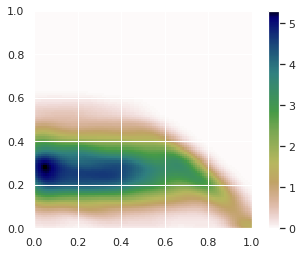

In [8]:
from scipy.stats import gaussian_kde

kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()

# Evaluation

In [9]:
def iou(pred_s, pred_e, true_s, true_e):
    assert true_s < true_e, "true value invalid: (%.2f, %.2f)"%(true_s, true_e)
    if pred_s > pred_e:
        print("predicted value invalid: (%.2f, %.2f)"%(pred_s, pred_e))
        return 0

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    return iou_val

def non_maximum_suppression(bbox, thresh, score=None, limit=None):
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = bbox[:, 1] - bbox[:, 0]

    selec = np.zeros(bbox.shape[0], dtype=bool)
    
    for i, b in enumerate(bbox):
        if not bbox_area[i] > 0:
            continue
            
        if not selec.any():
            selec[i] = True
            continue
            
        st = np.maximum(b[0], bbox[selec, 0])
        ed = np.minimum(b[1], bbox[selec, 1])
        area = (ed - st) * (st < ed)
            
        iou = area / (bbox_area[i] + bbox_area[selec] - area)
        
        # when the temporal bbox highly overlap with any of selected bbox
        if (iou >= thresh).any(): 
            continue

        selec[i] = True
        if limit is not None and np.count_nonzero(selec) >= limit:
            break
    
    selec = np.where(selec)[0]
    if score is not None:
        selec = order[selec]
    return selec.astype(np.int32)

In [11]:
results = {
    'R@1 IoU>.5': [],
    'R@1 IoU>.7': [],
    'R@5 IoU>.5': [],
    'R@5 IoU>.7': [],
}

test = DataLoader('data/processed/test.csv',
                  dict_file,
                  san_check=False)

test_iter = SerialIterator(test, b_size, repeat=False, shuffle=False)

iou_arr = []

for batch in test_iter:
    N = len(batch)
    x, y = cvrt_f(batch, device)
    
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        preds, probs = model.sample(x, 100)
    
    y = chainer.cuda.to_cpu(y)
    preds.to_cpu()
    preds = preds.data
    probs.to_cpu()
    probs = probs.data
    
    for i in range(N):
        # sort based on prob
        pred = preds[:, i, :]
        prob = probs[:, i]
#         sort_i = np.argsort(prob.data)[::-1]
#         pred = pred[sort_i][:5]
        
        selected = np.zeros((1,))
        thresh = .5
        while(selected.size < 5):
            selected = non_maximum_suppression(pred, thresh, prob)
            thresh += 0.2
        
        # format prediction
        start_t = pred[:, 0][selected][:5]
        duration = pred[:, 1][selected][:5]
        start_t = np.clip(start_t, 0, 1)
        duration = np.clip(duration, 0, 1)
        end_t = np.clip(start_t + duration, 0, 1)
        
        # eval iou
        gt_s, gt_d = y[i]
        gt_e = gt_s + gt_d
        ious = [iou(s, e, gt_s, gt_e) for s, e in zip(start_t, end_t)]
        iou_arr.append(ious)

iou_arr = np.asarray(iou_arr)
top_1 = iou_arr[:, 0]
results['R@1 IoU>.5'].append((top_1 > 0.5).mean()*100)
results['R@1 IoU>.7'].append((top_1 > 0.7).mean()*100)
results['R@5 IoU>.5'].append((np.max(iou_arr, axis=1) > 0.5).mean()*100)
results['R@5 IoU>.7'].append((np.max(iou_arr, axis=1) > 0.7).mean()*100)

KeyboardInterrupt: 

In [82]:
results

{'R@1 IoU>.5': [24.086021505376344],
 'R@1 IoU>.7': [8.629032258064516],
 'R@5 IoU>.5': [34.784946236559136],
 'R@5 IoU>.7': [17.661290322580644]}

In [229]:
results = {
    'R@1 IoU>.5': [],
    'R@1 IoU>.7': [],
    'R@5 IoU>.5': [],
    'R@5 IoU>.7': [],
}

for _ in range(100):
    
    pred, val = sg.sample(len(test_df)*5)
    pred[:, 1] = pred[:, 0] + pred[:, 1]  # convert (start, duration) -> (start, end)
    pred *= np.repeat(test_df['length'].values.reshape(-1, 1), 5)[:, None] # original scale (sec.)

    pred = np.split(pred, len(test_df))
    val = np.split(val, len(test_df))

    gt = test_df[['start (sec)', 'end (sec)']].values

    # compute R@1

    res = []
    for p_item, v_item, gt_item in zip(pred, val, gt):
        top_1 = p_item[np.argmax(v_item)]
        iou_val = iou(top_1[0], top_1[1], gt_item[0], gt_item[1])
        res.append(iou_val)

    results['R@1 IoU>.5'].append((np.asarray(res) > 0.5).mean()*100)
    results['R@1 IoU>.7'].append((np.asarray(res) > 0.7).mean()*100)
    
    # compute R@5

    res = []
    for p_item, gt_item in zip(pred, gt):
        iou_val = max([iou(p_item[j, 0], p_item[j, 1], gt_item[0], gt_item[1]) for j in range(5)])
        res.append(iou_val)
    
    results['R@5 IoU>.5'].append((np.asarray(res) > 0.5).mean()*100)
    results['R@5 IoU>.7'].append((np.asarray(res) > 0.7).mean()*100)

/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


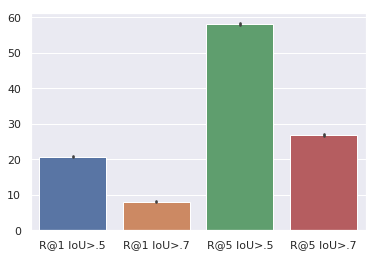

In [230]:
sns.barplot(data=pd.DataFrame(results), ci=100.)

In [232]:
pd.DataFrame(results).min()

R@1 IoU>.5    19.247312
R@1 IoU>.7     7.123656
R@5 IoU>.5    56.693548
R@5 IoU>.7    24.838710
dtype: float64

In [233]:
pd.DataFrame(results).mean()

R@1 IoU>.5    20.719624
R@1 IoU>.7     8.048925
R@5 IoU>.5    58.080108
R@5 IoU>.7    26.836290
dtype: float64

In [234]:
pd.DataFrame(results).max()

R@1 IoU>.5    22.204301
R@1 IoU>.7     9.193548
R@5 IoU>.5    60.000000
R@5 IoU>.7    28.817204
dtype: float64

max iou: 0.5


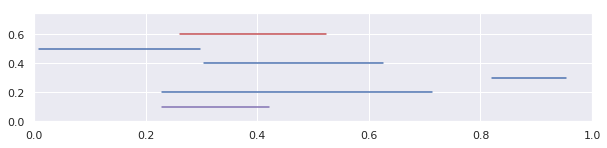

In [238]:
# show example
i = np.random.randint(len(test_df))
true_s, true_e = gt[i]
l = test_df['length'][i]
plt.figure(figsize=(10, 2))
plt.axhline(0.1, true_s/l, true_e/l, color='m')
plt.xlim((0, 1))
plt.ylim((0, .75))

p_item = pred[i]
# p_item = p_item.reshape(-1, 2)
offset = 0.2
iou_val = []
lines = []
for pred_s, pred_e in p_item:
    line = plt.axhline(offset, pred_s/l, pred_e/l, color='b')
    offset += 0.1
    iou_val.append(iou(pred_s, pred_e, true_s, true_e))
    lines.append(line)
print('max iou: %.1f' % max(iou_val))
if max(iou_val) > 0:
    lines[np.argmax(iou_val)].set_color('r')


 # ベースラインについて

 ## Random (sliding window)

 従来研究のRandomベースライン

 multi-scale temporal sliding window: {64, 128, 256, 512} frames and 80% overlap

 生成されたtemporal widowをランダムに選んだベースライン

 ## Random (KDE)

 segmentのstart timeとdurationをの確率密度関数をKDEで推定
 
 ランダムにサンプリング、生成されたサンプルをそのサンプル点での確率密度関数の値で並び替え


 ## 結果

 | method                             | R@1 IoU=0.5 | R@1 IoU=0.7 | R@5 IoU=0.5 | R@5 IoU=0.7 |
 |------------------------------------|------------:|------------:|------------:|------------:|
 | Random (sliding window)            |        8.51 |        3.03 |       37.12 |       14.06 |
 | Random (KDE)                       |       20.72 |        8.05 |       58.08 |       26.84 |
 | CTRL (ICCV'17)                     |       21.42 |        7.15 |       59.11 |       26.91 |
 | MAN (CVPR'19)                      |       46.53 |       22.72 |       86.23 |       53.72 |

 CTRL (Tall: Temporal activity localization via language query, ICCV'17)はRandom (KDE)とそんなに変わらない
 
 ただし、ベースラインはrandomなので多少スコアは上下する

 Tall論文ではもっと単純なRandomベースラインと比較してたけどあまり意味のないベースラインかも（弱すぎベースライン）

 データにバイアスがあるのでちょっとprior入れてやるだけで割とスコアは上がる

 ## メモ

 Tallはsliding windowベースの手法。多分そこがスコアのボトルネック

 candidate proposalの生成は少なくともデータセットの分布が反映される方法でやった方がいい（学習ベースの手法）

 queryの中の特定のphrase (eg., first time, after) を考慮するだけで結構スコア上がるのでは？